In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Lecture 11 - Model Validation
You might remember this code block from last class

In [3]:
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier as KNN
from matplotlib.colors import ListedColormap

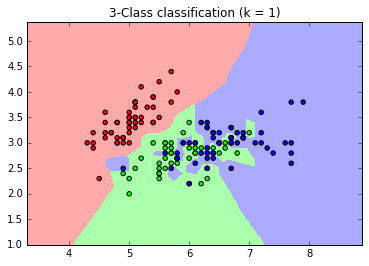

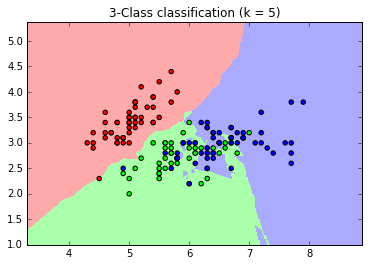

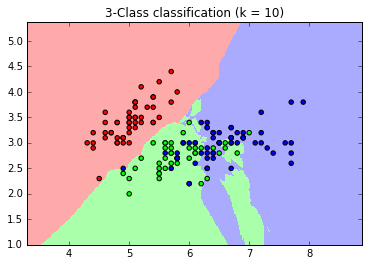

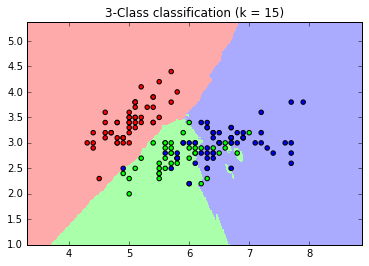

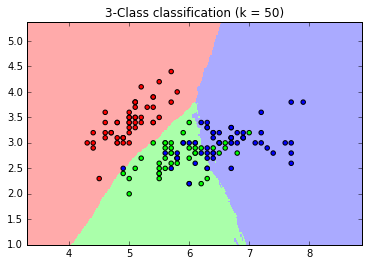

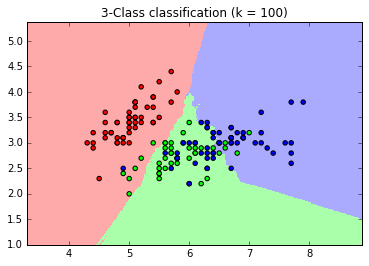

In [4]:
# import some data to play with
iris = datasets.load_iris()
X = iris.data[:, :2]  # we only take the first two features. We could
                      # avoid this ugly slicing by using a two-dim dataset
y = iris.target
h = .02  # step size in the mesh

# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

for n_neighbors in [1, 5, 10, 15, 50, 100]:

    # we create an instance of Neighbours Classifier and fit the data.
    clf = KNN(n_neighbors)
    clf.fit(X, y)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("3-Class classification (k = %i)" % (n_neighbors))

plt.show()

Which of the above plots are overfitting? underfitting? 
<br/><br/><br/>

## Cross-Validation
We've touched on the idea of overfitting a few times now, but I want to explore it again to really emphasize the importance of this method. This is probably the **most important step** of any machine learning / data science process. It asserts that your model can generalize (is not overfit) and makes sure that you're not wasting a clients money or time.

Before we proceed, let's import some data

In [36]:
from sklearn import datasets
from sklearn.cross_validation import cross_val_score, train_test_split
np.random.seed(30)

In [37]:
digits = datasets.load_digits()
X = digits.data
y = digits.target

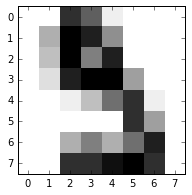

Corresponding digit 9


In [38]:
# Plot digit at position
digit_idx = 37 # the position of the digit to render 
plt.figure(1, figsize=(3, 3))
plt.imshow(X[digit_idx].reshape((8,8)), cmap=plt.cm.gray_r, interpolation='nearest')
plt.show()
print("Corresponding digit",y[digit_idx])

### Split test data from the training data
You may be asking yourself why are we separating a test set from the training set - isn't this what cross-validation already handles? 

We are basically getting the ability to assess how well our model will generalize. We'll use cross-validation (making the train-validation split of this training set) to evaluate subtle changes in our algorithm. Then we will use the test set to get an accuracy measurement for how well we expect our model to perform against new data.

In [39]:
X_train, X_test,y_train, y_test = train_test_split(X, y, test_size=0.2)

In [40]:
from sklearn.cross_validation import cross_val_score

In [41]:
clf = KNN(3)

clf_score = cross_val_score(clf, X_train, y_train,cv =5)
clf_score

array([ 0.98630137,  0.98269896,  0.98606272,  0.99300699,  0.97526502])

As you can see, `cross_val_score` outputs the validation accuracy values for each fold in the k-fold.

Let's make this into something a little bit more readable

In [42]:
def cv_stats(cv_score):
    """ Returns the mean and standard deviation in a readable format"""
    mean = np.mean(cv_score)
    std = np.std(cv_score)
    return mean, std
cv_stats(clf_score)

(0.98466701204912044, 0.0057696641477203063)

Now we're moving. How can we use this to our advantage?

**To pick our model hyperparameters of course!**

A good rule of thumb for picking model hyperparameters, as mentioned in last class, is to vary by order of magnitude at first, then explore the local neighborhood of values that seem relevant.

In [43]:
# start off with the lowest value possible, then multiply by 2 with every iteration
k = 2
while k < 100:
    clf = KNN(k)
    score = cross_val_score(clf, X_train, y_train, cv=5)
    stats = cv_stats(score)
    print("For k={0}", k, "; Average={0}, STDEV={1}".format(*stats))

    k *= 2

For k={0} 2 ; Average=0.9832587654725051, STDEV=0.005264042167244149
For k={0} 4 ; Average=0.9818649866629109, STDEV=0.004249198215732927
For k={0} 8 ; Average=0.9797984086988812, STDEV=0.002765149057643501
For k={0} 16 ; Average=0.9742590385428374, STDEV=0.004671507086804814
For k={0} 32 ; Average=0.9569093318506239, STDEV=0.010082879645926218
For k={0} 64 ; Average=0.9228193045465701, STDEV=0.009914917804725634


Not only can we evaluate how different hyperparameters affect the accuracy of a classifier, but we're also able to compare *different learning methods* as well!

Let's try logistic regression. First let's find the best parameter for C, the regularization term of logistic regression

In [44]:
from sklearn.linear_model import LogisticRegression, RidgeClassifier

In [45]:
penalty = 0.001
while penalty < 10:
    clf = LogisticRegression(C=penalty)
    score = cross_val_score(clf, X_train, y_train, cv=5)
    stats = cv_stats(score)
    print("For penalty={0}", penalty, "; Average={0}, STDEV={1}".format(*stats))
    penalty *= 5

For penalty={0} 0.001 ; Average=0.9464248990022102, STDEV=0.005958602819329075
For penalty={0} 0.005 ; Average=0.9603319159110099, STDEV=0.007201910121115308
For penalty={0} 0.025 ; Average=0.9652203171746594, STDEV=0.010505369591147075
For penalty={0} 0.125 ; Average=0.9630812871164209, STDEV=0.010140797642651241
For penalty={0} 0.625 ; Average=0.9623432950445864, STDEV=0.012597791183373962
For penalty={0} 3.125 ; Average=0.9546798701547073, STDEV=0.01603347762880108


And lets do the with RidgeClassifier. This algorithm basically implements Ridge Regression, a special case of Linear Regression. 

It basically attempts to limit large sizes of weights. If this is a little daunting, don't worry too much about it. A good explanation is located  [here](https://www.quora.com/What-is-Ridge-Regression-in-laymans-terms) if you are still curious

In [46]:
penalty = 0.001
while penalty < 10:
    clf = RidgeClassifier(alpha=penalty)
    score = cross_val_score(clf, X_train, y_train, cv=5)
    stats = cv_stats(score)
    print("For penalty={0}", penalty, "; Average={0}, STDEV={1}".format(*stats))
    penalty *= 5

For penalty={0} 0.001 ; Average=0.9360359633725766, STDEV=0.012403635009511076
For penalty={0} 0.005 ; Average=0.9360359633725766, STDEV=0.012403635009511076
For penalty={0} 0.025 ; Average=0.9360359633725766, STDEV=0.012403635009511076
For penalty={0} 0.125 ; Average=0.9360359633725766, STDEV=0.012403635009511076
For penalty={0} 0.625 ; Average=0.9367352640718772, STDEV=0.01253964011289812
For penalty={0} 3.125 ; Average=0.9374201955787266, STDEV=0.011940446535208683


From my results on cross-validation, it appears that the 4-NN algorithm outperforms all the other options. Given that, let's see how well our algorithm generalizes

In [88]:
clf=KNN(4)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test) 
accuracy = sum(predictions == y_test) / len(y_test)
accuracy

0.92982456140350878

And surprisingly enough, this test accuracy is higher - this is mostly a result of the toy datasets and random seeds. I'll explore this more in a later part of this notebook.

As a side note, we don't actually have to make our own accuracy calculations, Sklearn already implements that for us.

In [89]:
clf.score(X_test, y_test)

0.92982456140350878

## Introduction to Confusion Matrices
"How can we understand what types of mistakes a learned model makes? "

In [50]:
from sklearn.metrics import confusion_matrix

In [51]:

import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[35  0  0  0  0  0  0  0  0  0]
 [ 0 46  0  0  0  0  0  0  0  0]
 [ 0  0 41  0  0  0  0  0  0  0]
 [ 0  0  0 26  0  0  0  0  0  0]
 [ 0  1  0  0 34  0  0  0  0  0]
 [ 0  0  0  0  0 38  0  0  0  0]
 [ 0  0  0  0  0  0 42  0  0  0]
 [ 0  0  0  0  0  0  0 32  0  0]
 [ 0  1  0  1  0  0  0  0 33  0]
 [ 0  0  0  1  0  1  0  0  1 27]]


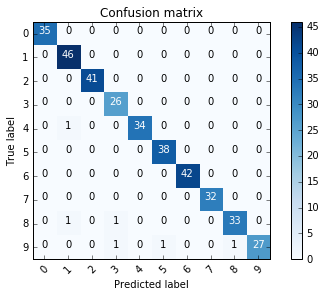

In [52]:
cnf_matrix = confusion_matrix(y_test, predictions)
plot_confusion_matrix(cnf_matrix, digits.target_names)

# Review of Models
1. Linear Regression
2. Logistic Regression
3. K-means
4. K-Nearest Neighbors
<br /><br /><br />


## Linear Regression
Answers the questions - "What's the best way to draw a line through our points?"

In [53]:
from sklearn import datasets
from sklearn.cross_validation import train_test_split
from sklearn import linear_model
import matplotlib.pyplot as plt

In [59]:
boston = datasets.load_boston()
X = boston.data
y = boston.target

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

In [60]:
linreg = linear_model.LinearRegression()
linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

#### Scoring our linear regression

If you remember from the linear regression lecture and from any stats class you've taken, the residual square error allows us to calculate how well our preidctor does in fitting the data. 
The formula is as so

$$R^2 = 1 - \frac{\sum(y_i - f(x_i))}{\sum(y_i-\bar{y})}$$,
where $f(x_i)$ is our model's prediction for the $x_i$th datapoint.

The great thing about sklearn's api is that a lot of these scoring measure are already built in. Using our trained Linear regressor, we can quickly score it using the score method as so

In [61]:
train_r2 = linreg.score(X_train, y_train)
test_r2 = linreg.score(X_test, y_test)

print("Train accuracy : ", train_r2)
print("Test accuracy : ", test_r2)

Train accuracy :  0.744898749918
Test accuracy :  0.708154688555


We can graphically examine how well our Linear Regressor performs by plotting the true y values, and those predicted by the linear regressor

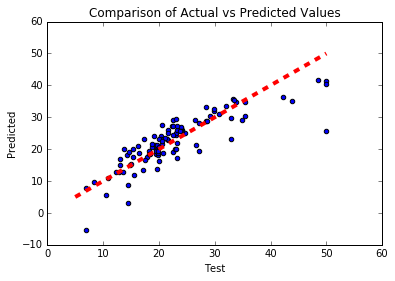

In [62]:
y_pred = linreg.predict(X_test)

fig, ax = plt.subplots()
ax.scatter(y_test, y_pred)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=4)
ax.set_xlabel('Test')
ax.set_ylabel('Predicted')
plt.title('Comparison of Actual vs Predicted Values')
plt.show()

## Logistic Regression
"Model the probability that some class occurs"

In [76]:
cancer = datasets.load_breast_cancer()
X = cancer.data
y = cancer.target

# np.random.seed(40) # example where test accuracy > train accuracy
np.random.seed(seed=133) # set seed=40 if you want an example where test accuracy is greater than train
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)


In [77]:
logreg = linear_model.LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [78]:
train_acc = logreg.score(X_train, y_train)
test_acc = logreg.score(X_test, y_test)


print("Train accuracy : ", train_acc)
print("Test accuracy : ", test_acc)

Train accuracy :  0.958241758242
Test accuracy :  0.947368421053


## k - Nearest Neighbors
" Find the `k` closest points in the training set that match the input datapoint "

In [79]:
from sklearn.neighbors import KNeighborsClassifier as KNN

In [80]:
knn = KNN(12)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=12, p=2,
           weights='uniform')

In [82]:
train_acc = knn.score(X_train, y_train)
test_acc = knn.score(X_test, y_test)


print("Train accuracy : ", train_acc)
print("Test accuracy : ", test_acc)

Train accuracy :  0.947252747253
Test accuracy :  0.938596491228


## K- means
Find `k` clusters in the data based on how similar each datapoint is to itself

In [83]:
from sklearn.cluster import KMeans
from matplotlib import cm

In [84]:
blobs = datasets.make_blobs(n_samples=1000)
X = blobs[0]
y = blobs[1]
clusterer = KMeans(n_clusters=3)
clusterer.fit(X)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=3, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [85]:
y_pred = clusterer.predict(X)

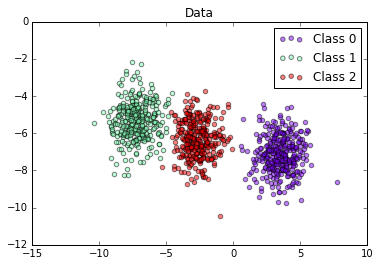

In [86]:
plt.figure()
y_unique = np.unique(y)
colors = cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
for this_y, color in zip(y_unique, colors):
    this_X = X[y_pred == this_y]
#     this_sw = sw_train[y == this_y]
    plt.scatter(this_X[:, 0], this_X[:, 1],  c=color, alpha=0.5,
                label="Class %s" % this_y)
plt.legend(loc="best")
plt.title("Data")
